In [1]:
import os
import wfdb
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def count_unique_records(base_folder):
    unique_records = set()

    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        record_per_file = 0
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.atr'):
                    record_name = file_name.split('.atr')[0]
                    unique_records.add(record_name)
                    record_per_file+=1

        print(f'There are {record_per_file} records in the folder {folder_name}.')
    return len(unique_records)

# Path to your data folder
data_folder = 'data'

# Count the unique records
num_records = count_unique_records(data_folder)
print(f'Total number of unique records: {num_records}')


There are 84 records in the folder long-term-af.
There are 18 records in the folder mit-bih-normal-sinus-rhythm-database-1.0.0.
Total number of unique records: 102


In [34]:
def count_unique_records_plus(base_folder):
    unique_records = set()
    hrv_lengths = []
    ecg_lengths = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        record_per_file = 0
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.atr'):
                    record_name = file_name.split('.atr')[0]
                    unique_records.add(record_name)
                    record_path = os.path.join(folder_path, record_name)

                    try:
                        # Read annotations
                        ann = wfdb.rdann(record_path, extension='atr')
                        record = wfdb.rdsamp(record_path)
                        # Extract RR intervals (in seconds)
                        rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]
                        
                        hrv_lengths.append(len(rr_intervals))

                        # Extract the signals
                        signal, fs = record[0][:,0], record[1]['fs']
                        # print(fs)
                        ecg_lengths.append(len(signal))

                        

                    except Exception as e:
                        print(f"Error processing {record_path}: {e}")
                    record_per_file+=1

        print(f'There are {record_per_file} records in the folder {folder_name}.')
    return len(unique_records), min(hrv_lengths), min(ecg_lengths)

# Path to your data folder
data_folder = 'data'

# Count the unique records
num_records, hrv_min_length, ecg_min_length = count_unique_records_plus(data_folder)
print(f'Total number of unique records: {num_records}.\n\
HRV_LENGTH = {hrv_min_length}.\n\
ECG_LENGTH = {ecg_min_length}.')

There are 84 records in the folder long-term-af.
There are 18 records in the folder mit-bih-normal-sinus-rhythm-database-1.0.0.
Total number of unique records: 102.
HRV_LENGTH = 31169.
ECG_LENGTH = 2826240.


In [4]:
HRV_LENGTH = hrv_min_length - 100
ECG_LENGTH = ecg_min_length - 100 # 2_826_240

In [5]:
def get_random_hrv_and_ecg(record_path, hrv_length = 20_000, ecg_length = 50_000):
    ann = wfdb.rdann(record_path, extension='atr')
    record = wfdb.rdsamp(record_path)
    # Extract RR intervals (in seconds)
    rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]

    length = len(rr_intervals)
    # print(length)
    start_index = np.random.randint(0,length-hrv_length)
    rr_intervals = rr_intervals[start_index : (start_index+hrv_length)]
    # hrv_signals.append(rr_intervals)

    # Extract the signals
    signal, fs = record[0][:,0], record[1]['fs']
    length = len(signal)
    start_index = np.random.randint(0,length-ecg_length)
    signal = signal[start_index : (start_index+ecg_length)]
    # ecg_signals.append(signal)
    return rr_intervals, signal

In [6]:
def better_better_calculate_ecg_and_hrv_signals(base_folder, nb_train_examples=200, nb_test_examples=100, hrv_length = 20_000, ecg_length = 50_000, test_ratio=0.2):
    assert(hrv_length < HRV_LENGTH)
    assert(ecg_length < ECG_LENGTH)
    train_hrv_signals = []
    test_hrv_signals = []
    train_ecg_signals = []
    test_ecg_signals = []
    label = 0
    y_train = []
    y_test = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        file_names = [file_name.split('.atr')[0] for file_name in file_names if file_name.endswith('.atr')]
        random.shuffle(file_names)
        nb_files = len(file_names)
        n_test = int(test_ratio*nb_files)
        n_train = nb_files - n_test
        
        test_files = file_names[:n_test]
        train_files = file_names[n_test:]
        
        nb_files = len(file_names)
        for _ in range(nb_train_examples):
            record_name = train_files[np.random.randint(len(train_files))]
            record_path = os.path.join(folder_path, record_name)
            hrv, ecg = get_random_hrv_and_ecg(record_path, hrv_length=hrv_length,ecg_length=ecg_length)
            train_hrv_signals.append(hrv)
            train_ecg_signals.append(ecg)
            y_train.append(label)

        for _ in range(nb_test_examples):
            record_name = test_files[np.random.randint(len(test_files))]
            record_path = os.path.join(folder_path, record_name)
            hrv, ecg = get_random_hrv_and_ecg(record_path, hrv_length=hrv_length,ecg_length=ecg_length)
            test_hrv_signals.append(hrv)
            test_ecg_signals.append(ecg)
            y_test.append(label)

        label += 1
    # Convert the list of HRV features to a numpy array
    train_hrv_array = np.array(train_hrv_signals)
    test_hrv_array = np.array(test_hrv_signals)
    train_ecg_array = np.array(train_ecg_signals)
    test_ecg_array = np.array(test_ecg_signals)

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return train_ecg_array, train_hrv_array, y_train,\
           test_ecg_array, test_hrv_array, y_test

# Example usage
data_folder = 'data'
ecg_train, hrv_train, y_train, ecg_test, hrv_test, y_test = better_better_calculate_ecg_and_hrv_signals(data_folder, hrv_length = 25_000, ecg_length = 50_000)

In [7]:
def plot_mean_std(arr):
    plt.errorbar(range(arr.shape[0]),arr.mean(axis=-1),arr.std(axis=-1))

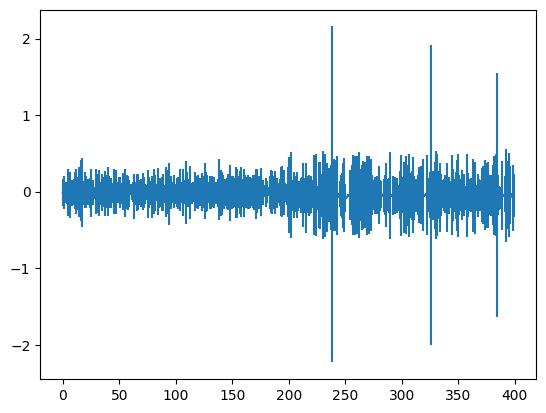

In [8]:
plot_mean_std(ecg_train)

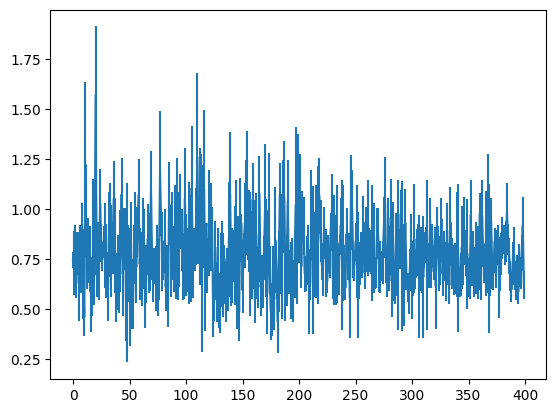

In [9]:
plot_mean_std(hrv_train)

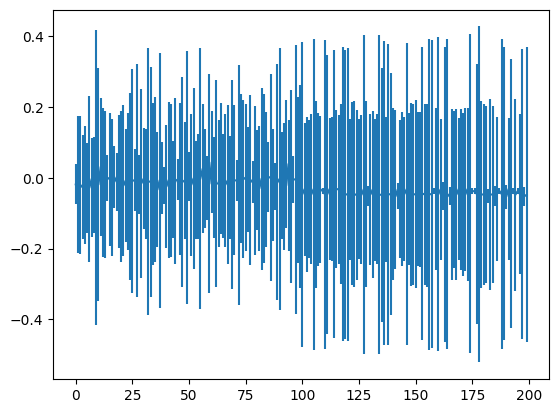

In [10]:
plot_mean_std(ecg_test)

In [17]:
ecg_test[indices,:].shape

(1, 30, 50000)

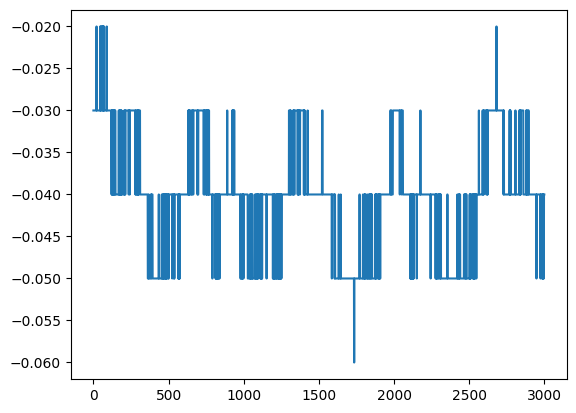

In [32]:
indices = np.where(ecg_test.std(axis=-1) < 0.1)

plt.plot(ecg_test[indices,:].squeeze()[28,12_000:15_000]);

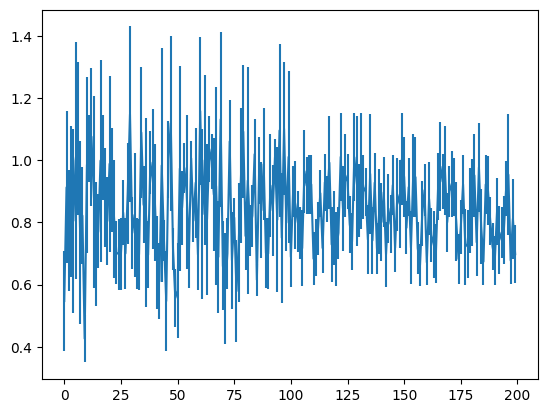

In [12]:
plot_mean_std(hrv_test)

In [13]:
train_hrv_data = np.concatenate([hrv_train,y_train[:,None]], axis=-1)
train_ecg_data = np.concatenate([ecg_train,y_train[:,None]], axis=-1)

np.save('train_hrv_data', train_hrv_data)
np.save('train_ecg_data', train_ecg_data)

test_hrv_data = np.concatenate([hrv_test,y_test[:,None]], axis=-1)
test_ecg_data = np.concatenate([ecg_test,y_test[:,None]], axis=-1)

np.save('test_hrv_data', test_hrv_data)
np.save('test_ecg_data', test_ecg_data)

In [14]:
stop

NameError: name 'stop' is not defined

In [ ]:
def better_calculate_ecg_and_hrv_signals(base_folder, example_per_file = 200, hrv_length = 20_000, ecg_length = 1_000_000):
    assert(hrv_length < HRV_LENGTH)
    assert(ecg_length < ECG_LENGTH)
    hrv_signals = []
    ecg_signals = []
    label = 0
    y = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        file_names = [file_name.split('.atr')[0] for file_name in file_names if file_name.endswith('.atr')]
        nb_files = len(file_names)
        for _ in range(example_per_file):
            record_name = file_names[np.random.randint(nb_files)]
            record_path = os.path.join(folder_path, record_name)


            # try:
            if True:
                # Read annotations
                ann = wfdb.rdann(record_path, extension='atr')
                record = wfdb.rdsamp(record_path)
                # Extract RR intervals (in seconds)
                rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]

                length = len(rr_intervals)
                # print(length)
                start_index = np.random.randint(0,length-hrv_length)
                rr_intervals = rr_intervals[start_index : (start_index+hrv_length)]
                hrv_signals.append(rr_intervals)

                # Extract the signals
                signal, fs = record[0][:,0], record[1]['fs']
                length = len(signal)
                start_index = np.random.randint(0,length-ecg_length)
                signal = signal[start_index : (start_index+ecg_length)]
                ecg_signals.append(signal)
                y.append(label)
                

            # except Exception as e:
            #     print(f"Error processing {record_path}: {e}")
        label += 1
    # Convert the list of HRV features to a numpy array
    hrv_array = np.array(hrv_signals)
    ecg_array = np.array(ecg_signals)
    return   ecg_array, hrv_array, np.array(y)

# Example usage
data_folder = 'data'
ecgs, hrvs, labels = better_calculate_ecg_and_hrv_signals(data_folder, example_per_file = 200, hrv_length = 25_000, ecg_length = 50_000)

In [ ]:
ecgs.shape

(400, 50000)

In [ ]:
hrv_data = np.concatenate([hrvs,labels[:,None]], axis=-1)
ecg_data = np.concatenate([ecgs,labels[:,None]], axis=-1)
np.save('better_hrv_data', hrv_data)
np.save('better_ecg_data', ecg_data)

In [ ]:
def calculate_ecg_and_hrv_signals(base_folder, hrv_length = 20_000, ecg_length = 1_000_000):
    hrv_signals = []
    ecg_signals = []
    label = 0
    y = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            if file_name.endswith('.atr'):
                record_name = file_name.split('.atr')[0]
                record_path = os.path.join(folder_path, record_name)

                try:
                    # Read annotations
                    ann = wfdb.rdann(record_path, extension='atr')
                    record = wfdb.rdsamp(record_path)
                    # Extract RR intervals (in seconds)
                    rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]
                    rr_intervals = rr_intervals[:hrv_length]
                    hrv_signals.append(rr_intervals)

                    # Extract the signals
                    signal, fs = record[0][:ecg_length,0], record[1]['fs']
                    ecg_signals.append(signal)
                    y.append(label)
                    

                except Exception as e:
                    print(f"Error processing {record_path}: {e}")
        label += 1
    # Convert the list of HRV features to a numpy array
    hrv_array = np.array(hrv_signals)
    ecg_array = np.array(ecg_signals)
    return   ecg_array, hrv_array, np.array(y)

# Example usage
data_folder = 'data'
ecgs, hrvs, labels = calculate_ecg_and_hrv_signals(data_folder, hrv_length = 30_000, ecg_length = 50_000)

In [ ]:
def plot_mean_std(arr):
    plt.errorbar(arr.mean(axis=-1),arr.std(axis=-1))

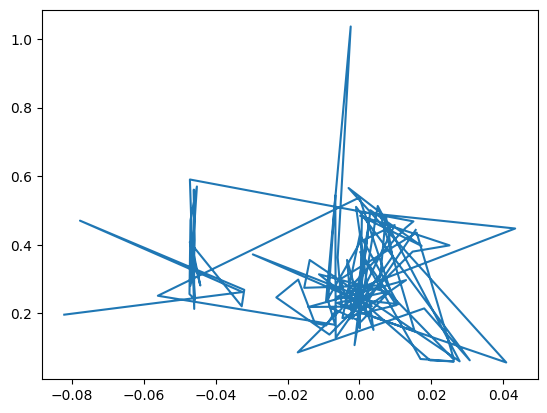

In [ ]:
plot_mean_std(ecgs)

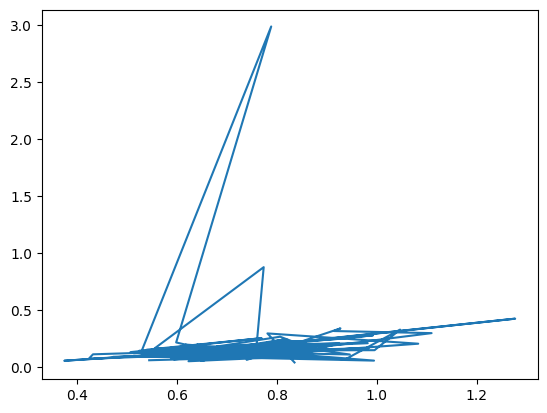

In [ ]:
plot_mean_std(hrvs)

In [ ]:
ecgs.shape

(102, 50000)

In [ ]:
hrv_data = np.concatenate([hrvs,labels[:,None]], axis=-1)
ecg_data = np.concatenate([ecgs,labels[:,None]], axis=-1)
np.save('med_hrv_data', hrv_data)
np.save('med_ecg_data', ecg_data)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
def calculate_ecg_signals(base_folder):
    hrv_batches = []
    label = 0
    y = []
    fss = list()
    min_length = np.inf
    signals = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            if file_name.endswith('.hea'):
                record_name = file_name.split('.hea')[0]
                record_path = os.path.join(folder_path, record_name)

                # try:
                if True:
                    # Read the record
                    record = wfdb.rdsamp(record_path)

                    # Extract the signals
                    signal, fs = record[0][:LENGTH,0], record[1]['fs']
                    signals.append(signal)
                    y.append(label)
                # except Exception as e:
                #     print(f"Error processing {record_path}: {e}")
        label += 1
    return np.array(signals), np.array(y)

In [ ]:
def reshape_to_batches(array, m):
    """
    Transform an array of shape (n,) into a list of arrays of shape (m,).
    """
    array = np.asarray(array)
    n = array.shape[0]
    num_batches = n // m
    return [array[i * m:(i + 1) * m] for i in range(num_batches)]

def calculate_hrv_signals(base_folder, batch_size=10_000):
    hrv_batches = []
    label = 0
    y = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            if file_name.endswith('.atr'):
                record_name = file_name.split('.atr')[0]
                record_path = os.path.join(folder_path, record_name)

                try:
                    # Read annotations
                    ann = wfdb.rdann(record_path, extension='atr')

                    # Extract RR intervals (in seconds)
                    rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]
                    # print(rr_intervals.shape)

                    # Batch the RR intervals
                    rr_batches = reshape_to_batches(rr_intervals, batch_size)

                    # Calculate HRV features for each batch and store them
                    for batch in rr_batches:
                        # sdnn = np.std(batch)
                        # rmssd = np.sqrt(np.mean(np.diff(batch)**2))
                        # mean_rr = np.mean(batch)
                        hrv_batches.append(batch)
                        y.append(label)

                except Exception as e:
                    print(f"Error processing {record_path}: {e}")
        label += 1
    # Convert the list of HRV features to a numpy array
    hrv_batches_array = np.array(hrv_batches)

    return hrv_batches_array, np.array(y)

# Example usage
data_folder = 'data'
hrv_signals_array,y = calculate_hrv_signals(data_folder, batch_size=10_000)

# Print the shape of the concatenated HRV features array
print(f"Shape of HRV signals array: {hrv_signals_array.shape}")

# Print the first few HRV feature sets
print(hrv_signals_array.shape)


Shape of HRV signals array: (1036, 10000)
(1036, 10000)


## Remove outliers

<ErrorbarContainer object of 3 artists>

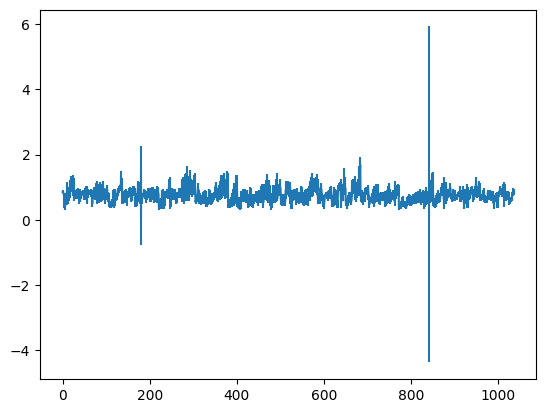

In [ ]:
plt.errorbar(np.arange(hrv_signals_array.shape[0]),hrv_signals_array.mean(axis=-1),hrv_signals_array.std(axis=-1))

In [ ]:
outliers = np.where(hrv_signals_array.std(axis=-1) > 0.5)
outliers

(array([179, 181, 842], dtype=int64),)

In [ ]:
hrvs = np.delete(hrv_signals_array,outliers,axis= 0)
y = np.delete(y,outliers,axis= 0)

<ErrorbarContainer object of 3 artists>

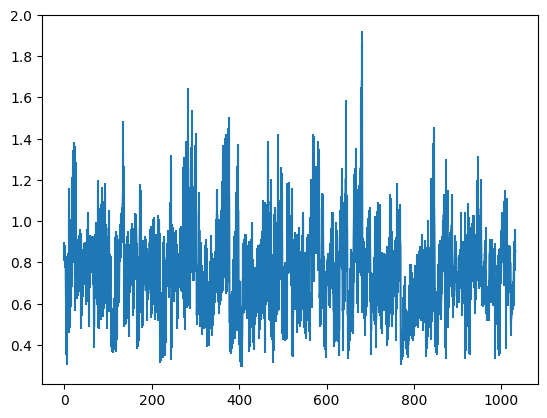

In [ ]:
plt.errorbar(np.arange(hrvs.shape[0]),hrvs.mean(axis=-1),hrvs.std(axis=-1))

## Balance classes

In [ ]:
examples_per_class = int(min(y.sum(),y.shape[0]-y.sum()))
examples_per_class 

173

In [ ]:
data = np.concatenate([hrvs,np.expand_dims(y,-1)],axis=-1)

In [ ]:
data.shape

(1033, 10001)

In [ ]:
data0 = data[np.where(1 - y),:].squeeze()
data1 = data[np.where(y),:].squeeze()
data0.shape

(860, 10001)

In [ ]:
reduced_data0 = data0[np.random.permutation(data0.shape[0]),:][:examples_per_class,:]
reduced_data1 = data1[np.random.permutation(data1.shape[0]),:][:examples_per_class,:]

In [ ]:
reduced_data0.shape

(173, 10001)

In [ ]:
balanced_data = np.concatenate([reduced_data0,reduced_data1],axis=0)

In [ ]:
print(balanced_data.shape)

(346, 10001)


In [ ]:
np.save('hrv_data_good', balanced_data)

In [ ]:
# n0, n1 = hrvs.shape

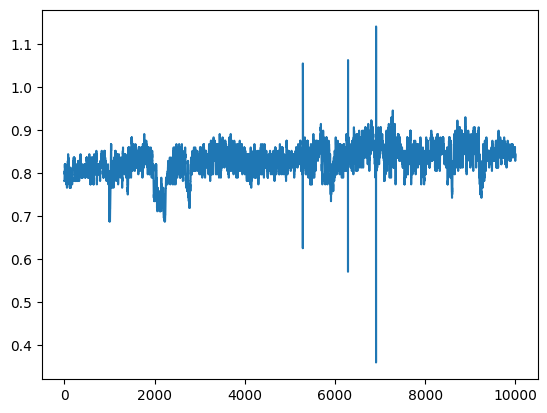

In [ ]:
plt.plot(hrvs[np.random.permutation(100),:][:1,:].T);

In [ ]:
# plt.plot(hrv_signals_array[842][10:])

## Prep ECG

In [ ]:
def count_unique_records(base_folder):
    unique_records = set()

    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        record_per_file = 0
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.hea'):
                    record_name = file_name.split('.hea')[0]
                    unique_records.add(record_name)
                    record_per_file+=1

        print(f'There are {record_per_file} records in the folder {folder_name}.')
    return len(unique_records)

# Path to your data folder
data_folder = 'data'

# Count the unique records
num_records = count_unique_records(data_folder)
print(f'Total number of unique records: {num_records}')


There are 84 records in the folder long-term-af.
There are 18 records in the folder mit-bih-normal-sinus-rhythm-database-1.0.0.
Total number of unique records: 102


In [ ]:
def reshape_to_batches(array, m):
    """
    Transform an array of shape (n,) into a list of arrays of shape (m,).
    """
    array = np.asarray(array)
    n = array.shape[0]
    num_batches = n // m
    return [array[i * m:(i + 1) * m] for i in range(num_batches)]

def calculate_hrv_signals(base_folder, batch_size=10_000):
    hrv_batches = []
    label = 0
    y = []
    fss = list()
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            if file_name.endswith('.hea'):
                record_name = file_name.split('.hea')[0]
                record_path = os.path.join(folder_path, record_name)

                try:
                #if True:
                    # Read the record
                    # print(record_path)
                    record = wfdb.rdsamp(record_path)
                    # print(record)
                    # Extract the signals
                    signals, fs = record[0][:,0], record[1]['fs']
                    # print(signals.shape)
                    fss.append(fs)
                    # resampled_signal = resample_signal(signals, fs, target_fs)
                    # Extract RR intervals (in seconds)
                    # rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]
                    # print(rr_intervals.shape)

                    # Batch the RR intervals
                    signal_batches = reshape_to_batches(signals, batch_size)
                    # signal_batches = [signals]
                    # Calculate HRV features for each batch and store them
                    for batch in signal_batches:
                        # sdnn = np.std(batch)
                        # rmssd = np.sqrt(np.mean(np.diff(batch)**2))
                        # mean_rr = np.mean(batch)
                        signal_batches.append(batch)
                        y.append(label)

                except Exception as e:
                    print(f"Error processing {record_path}: {e}")
        label += 1
    for signal in signal_batches:
        print(signal.shape)
    # # Convert the list of HRV features to a numpy array
    print(np.unique(fss))
    hrv_batches_array = np.array(signal_batches)
    
    return hrv_batches_array, np.array(y)

# # Example usage
# data_folder = 'data'
hrv_signals_array,y = calculate_hrv_signals(data_folder, batch_size=10_000)

# # Print the shape of the concatenated HRV features array
# print(f"Shape of HRV signals array: {hrv_signals_array.shape}")

# # Print the first few HRV feature sets
# print(hrv_signals_array.shape)


Error processing data\long-term-af\00: 
Error processing data\long-term-af\01: 
Error processing data\long-term-af\03: 
Error processing data\long-term-af\05: 
Error processing data\long-term-af\06: 
Error processing data\long-term-af\07: 
Error processing data\long-term-af\08: 
Error processing data\long-term-af\10: 
Error processing data\long-term-af\100: 
Error processing data\long-term-af\101: 
Error processing data\long-term-af\102: 
Error processing data\long-term-af\103: 
Error processing data\long-term-af\104: 
Error processing data\long-term-af\105: 
Error processing data\long-term-af\11: 
Error processing data\long-term-af\110: 
Error processing data\long-term-af\111: 
Error processing data\long-term-af\112: 
Error processing data\long-term-af\113: 
Error processing data\long-term-af\114: 
Error processing data\long-term-af\115: 
Error processing data\long-term-af\116: 
Error processing data\long-term-af\117: 
Error processing data\long-term-af\118: 
Error processing data\lon

In [ ]:
LENGTH = 2826240

In [ ]:
def calculate_ecg_signals(base_folder):
    hrv_batches = []
    label = 0
    y = []
    fss = list()
    min_length = np.inf
    signals = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            if file_name.endswith('.hea'):
                record_name = file_name.split('.hea')[0]
                record_path = os.path.join(folder_path, record_name)

                # try:
                if True:
                    # Read the record
                    record = wfdb.rdsamp(record_path)

                    # Extract the signals
                    signal, fs = record[0][:LENGTH,0], record[1]['fs']
                    signals.append(signal)
                    y.append(label)
                # except Exception as e:
                #     print(f"Error processing {record_path}: {e}")
        label += 1
    return np.array(signals), np.array(y)

# # Example usage
# data_folder = 'data'
signals_array,y = calculate_ecg_signals(data_folder)
# calculate_hrv_signals(data_folder)
ecg_data_good = np.concatenate([signals_array,y[:,None]],axis=-1)

In [ ]:
np.concatenate([np.array([1,2,3]),np.array([2,3,4])],axis=0)

array([1, 2, 3, 2, 3, 4])

In [ ]:
signals_array.shape

(102, 2826240)

In [ ]:
np.save('ecg_data_good',ecg_data_good)

In [ ]:
hrv_signals_array.shape

(1071, 10000)

In [ ]:
record_path = "data/long-term-af/03"
record1 = wfdb.rdsamp(record_path)
# print(record)
# Extract the signals
signals1, fs1 = record1[0], record1[1]['fs']
print(record1)

(array([[ 0.03458003, -0.00494   ],
       [ 0.03458003, -0.00494   ],
       [ 0.04940004, -0.00494   ],
       ...,
       [ 0.07410005,  0.09880007],
       [ 0.06916005,  0.08892007],
       [ 0.06916005,  0.11362008]]), {'fs': 128, 'sig_len': 11182080, 'n_sig': 2, 'base_date': datetime.date(2003, 7, 18), 'base_time': datetime.time(17, 55, 42), 'units': ['mV', 'mV'], 'sig_name': ['ECG', 'ECG'], 'comments': []})


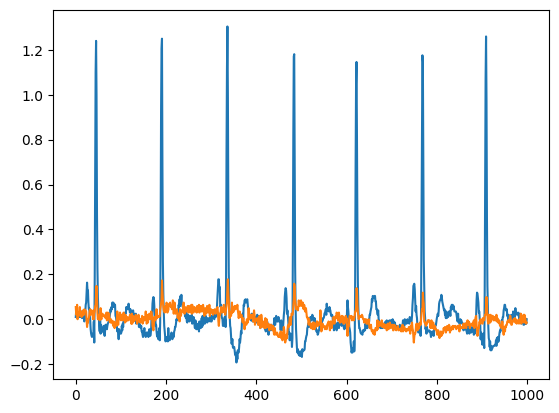

In [ ]:
plt.plot(signals1[29_000:30_000])

In [ ]:
record_path = "data/mit-bih-normal-sinus-rhythm-database-1.0.0/19830"
record2 = wfdb.rdsamp(record_path)
# print(record)
# Extract the signals
signals2, fs2 = record2[0], record2[1]['fs']
print(record2)

(array([[-0.435, -0.425],
       [-0.435, -0.415],
       [-0.415, -0.405],
       ...,
       [-0.1  ,  0.   ],
       [-0.09 ,  0.   ],
       [-0.1  ,  0.   ]]), {'fs': 128, 'sig_len': 10701824, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(9, 56), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': ['50 F']})


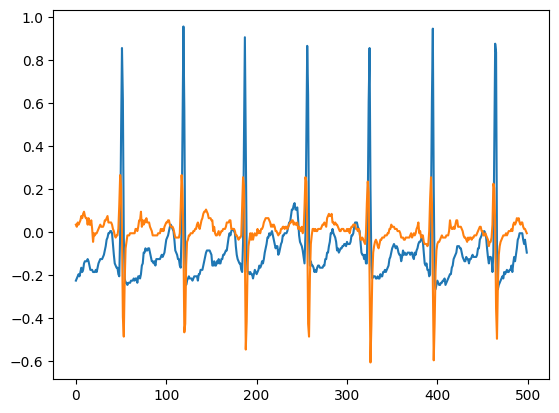

In [ ]:
plt.plot(signals2[30_500:31000])

In [ ]:
record

NameError: name 'record' is not defined